# Porównanie 3 metod regresji na podstawie 3 różnych zbiorów danych: Ceny domów w Melbourne

W niniejszej pracy wykorzystuję metody:
- K najbliższych sąsiądów (KNN)
- Regresji liniowej
- Lasu losowego

Używam następujących zbiorów danych:
- [Melbourne Housing](https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot) 
    - zmienna objaśniana: cena domu

## Załadowanie potrzebnych bibliotek

In [35]:
import random
import os
from joblib import dump, load

import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import mlflow

%load_ext dotenv
%dotenv ../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## Stałe

In [2]:
random_state = 0

np.random.seed(random_state)
os.environ["PYTHONHASHSEED"] = str(random_state)
random.seed(random_state)

In [5]:
# if you want to log mlflow and you have the server configured change to True
want_to_log_mlflow = False

log_mlflow = "MLFLOW_TRACKING_URI" in os.environ and want_to_log_mlflow
if log_mlflow: mlflow.set_experiment("Housing")

In [6]:
sklearn.set_config(transform_output="pandas")

In [36]:
plt.style.use("ggplot")

## Wczytanie danych

In [7]:
housing = pd.read_csv("../data/melb_data.csv")

### Krótka analiza eksploracyjna danych

In [8]:
# uncomment if you want to create an automated EDA report
# ProfileReport(dataset, title=f"Profiling Report for Housing dataset").to_file(f"../data/housing_EDA.html")

## Preprocessing

In [9]:
housing.sample(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
8505,Williamstown,44 Electra St,4,h,2165000.0,SP,Greg,6/05/2017,8.0,3016.0,...,2.0,2.0,450.0,190.0,1910.0,Hobsons Bay,-37.86100,144.89850,Western Metropolitan,6380.0
5523,Seddon,80 Gamon St,2,h,815000.0,S,Chisholm,30/07/2016,6.6,3011.0,...,1.0,0.0,172.0,81.0,1900.0,Maribyrnong,-37.81000,144.88960,Western Metropolitan,2417.0
12852,Sunshine North,6 Melton Av,3,h,610000.0,SP,Sweeney,16/09/2017,10.5,3020.0,...,1.0,1.0,581.0,NaN,NaN,NaN,-37.76740,144.82421,Western Metropolitan,4217.0
4818,Prahran,16 Park Rd,3,t,1245000.0,PI,Marshall,6/08/2016,4.5,3181.0,...,2.0,1.0,128.0,134.0,2000.0,Stonnington,-37.85260,145.00710,Southern Metropolitan,7717.0
12812,Pascoe Vale,13 Yorkshire St,3,h,1160000.0,S,Nelson,16/09/2017,8.5,3044.0,...,2.0,2.0,480.0,NaN,NaN,NaN,-37.72523,144.94567,Northern Metropolitan,7485.0


In [10]:
housing.isna().sum().sort_values(ascending=False).head(5)

BuildingArea    6450
YearBuilt       5375
CouncilArea     1369
Car               62
Suburb             0
dtype: int64

In [11]:
X = housing.drop(columns="Price")
y = housing["Price"]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=random_state)

In [13]:
imputer = ColumnTransformer([("mode_imputer", SimpleImputer(strategy="most_frequent"), ["YearBuilt", "CouncilArea", "Car"]),
                                ("mean_imputer", SimpleImputer(strategy="mean"), ["BuildingArea"]),
                                ],
                               remainder="passthrough",
                               n_jobs=-1,
                               verbose=True,
                               verbose_feature_names_out=False,
                               )

In [14]:
encoder= ColumnTransformer([("target_encoder", TargetEncoder(categories="auto", target_type="continuous", random_state=random_state), ["SellerG", "Postcode", "Regionname", "CouncilArea", "Postcode", "Suburb"]),
                                ("one_hot_encoder", OneHotEncoder(sparse_output=False), ["Type", "Method"]),
                                     ("drop", "drop", ["Address", "Lattitude", "Longtitude", "Date"])
                                ],
                               remainder="passthrough",
                               n_jobs=-1,
                               verbose=True,
                               verbose_feature_names_out=False,
                               )

In [15]:
preprocessing_pipe = make_pipeline(imputer, encoder, verbose=True)
preprocessing_pipe

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['YearBuilt', 'CouncilArea',
                                                   'Car']),
                                                 ('mean_imputer',
                                                  SimpleImputer(),
                                                  ['BuildingArea'])],
                                   verbose=True,
                                   verbose_feature_names_out=False)),
                ('columntransformer-2',
                 ColumnTransformer(n_jobs=-1, remai...
                                   transformers=[('target_encoder',
                                                  TargetEncoder(random_state=0,
                                                                target_type='continuous'),
                                                  ['SellerG', 'Postcode',
                                                   'Regionname', 'CouncilArea',
                                                   'Postcode', 'Suburb']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Type', 'Method']),
                                                 ('drop', 'drop',
                                                  ['Address', 'Lattitude',
                                                   'Longtitude', 'Date'])],
                                   verbose=True,
                                   verbose_feature_names_out=False))],
         verbose=True)

In [16]:
X_train_preprocessed = preprocessing_pipe.fit_transform(X_train, y_train)

[Pipeline]  (step 1 of 2) Processing columntransformer-1, total=   2.4s
[Pipeline]  (step 2 of 2) Processing columntransformer-2, total=   4.0s


# Modelowanie

In [17]:
knn_params = {"n_neighbors": [5, 25, 50],
                "weights": ["uniform", "distance"],
                "leaf_size": [20, 30, 50],
                "p": [1, 2],
                }

random_forest_params = {"n_estimators": [50, 100, 200],
                          # "criterion": ["squared_error", "absolute_error"],
                          "max_depth": [None, 3, 4, 5],
                          "max_features": [None, "sqrt", "log2"],
                          }

Przy wyczerpującym przeszukiwania siatki parametrów w celu znalezienia najlepszej kombinacji parametrów użyjemy walidacji krzyżowej .

[<img src="../img/grid_search_cross_validation.png" alt="drawing" width="400"/>]("../img/grid_search_cross_validation.png") \
źródło: https://scikit-learn.org/stable/modules/cross_validation.html

In [18]:
folds = KFold(n_splits=5, shuffle=True, random_state=random_state)

## Housing

### Regresja liniowa

In [19]:
linreg = LinearRegression(n_jobs=-1)

In [20]:
linreg.fit(X_train_preprocessed, y_train)

LinearRegression(n_jobs=-1)

In [21]:
linreg.score(X_train_preprocessed, y_train)

0.6558481241982778

### K najbliższych sąsiadów

In [41]:
search_knn = GridSearchCV(estimator=KNeighborsRegressor(n_jobs=-1),
                           param_grid=knn_params,
                           scoring="r2",
                           n_jobs=-1,
                           refit=True,
                           cv=folds,
                           return_train_score=True,
                           verbose=3,
                           )

In [42]:
%%time
search_knn.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 3.34 s
Wall time: 2min 26s


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=KNeighborsRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'leaf_size': [20, 30, 50], 'n_neighbors': [5, 25, 50],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='r2', verbose=3)

In [27]:
## uncomment if you want to save you model
# dump(search_knn, "../models/search_knn_housing.joblib")
## uncomment if you want load a saved model
# search_knn = load("../models/search_knn_housing.joblib")

['../models/clf_knn_housing.joblib']

In [33]:
pd.DataFrame(search_knn.cv_results_);

### Las losowy

In [20]:
search_random_forest = GridSearchCV(estimator=RandomForestRegressor(random_state=random_state),
                                           param_grid=random_forest_params,
                                           scoring="r2",
                                           n_jobs=-1,
                                           refit=True,
                                           cv=folds,
                                           return_train_score=True,
                                         verbose=3,
                                        )

In [21]:
%%time
search_random_forest.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 49.3 s
Wall time: 4min 26s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 4, 5],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='r2', verbose=3)

In [25]:
# uncomment if you want to save you model
# dump(search_random_forest, "../models/search_random_forest_housing.joblib")
# uncomment if you want load a saved model
# search_random_forest = load("../models/search_random_forest_housing.joblib")

['../models/clf_random_forest_housing.joblib']

In [32]:
pd.DataFrame(search_random_forest.cv_results_);

## Analysis

In [26]:
final_models = [("linear_regression", linreg), ("knn", search_knn.best_estimator_), ("random_forest", search_random_forest.best_estimator_)]

In [28]:
rows = []

for model_name, model in final_models:
    params = search_random_forest.best_estimator_.get_params()
    
    y_pred = model.predict(preprocessing_pipe.transform(X_test))
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {"mae": mae, "mse": mse, "mape": mape, "rmse": rmse, "r2": r2}
    rows.append(metrics)

    if log_mlflow:
        with mlflow.start_run(run_name=model_name) as run:
            mlflow.log_params(params)
            mlflow.log_metrics(metrics)
            
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="housing",
                input_example=X_test,
            )

In [29]:
results = pd.DataFrame(rows, index=[tpl[0] for tpl in final_models])

In [31]:
results.style.format(precision=2, thousands=",")

,mae,mse,mape,rmse,r2
linear_regression,"245,144.38","129,097,191,183.09",0.25,"359,300.98",0.67
knn,"343,499.24","258,551,994,623.27",0.38,"508,480.08",0.34
random_forest,"172,985.50","74,971,653,156.67",0.16,"273,809.52",0.81


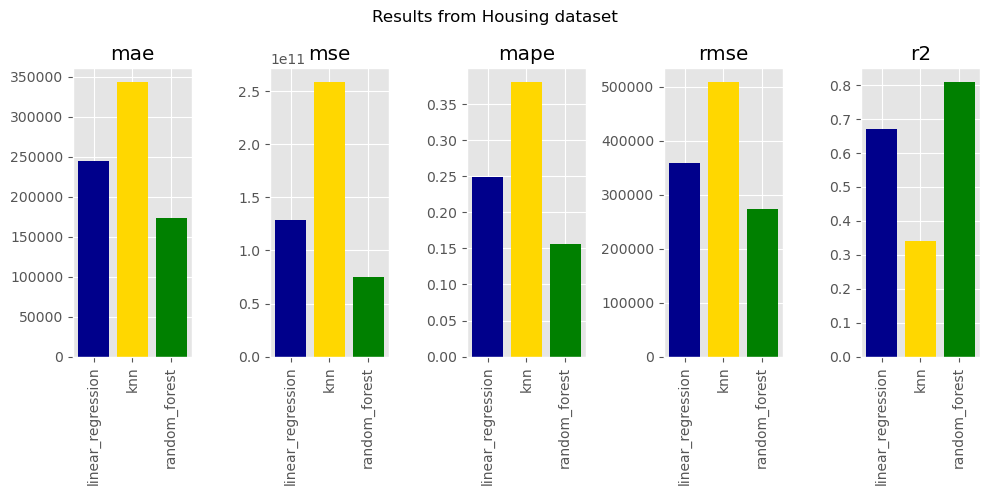

In [37]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
colors = ["darkblue", "gold", "green"]

metrics = results.columns
for i, metric in enumerate(metrics):
    axes[i].bar(results.index, results[metric], color=colors)
    axes[i].set_title(metric)
    axes[i].xaxis.set_ticks([0, 1, 2], results.index, rotation=90)

fig.suptitle("Results from Housing dataset")
plt.tight_layout()
plt.show()
